In [1]:
# Install TensorFlow 2.15.0 if not already installed
import sys
!{sys.executable} -m pip install tensorflow==2.15.0 --quiet

# Restart the kernel is recommended after installation
# Then import required modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Verify installation
print("TensorFlow version:", tf.__version__)
print("Imports successful")



TensorFlow version: 2.15.0
Imports successful


 X_train shape: (1128, 30, 3)
 y_train shape: (1128,)
 X_val shape: (282, 30, 3)
 y_val shape: (282,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17408     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                  

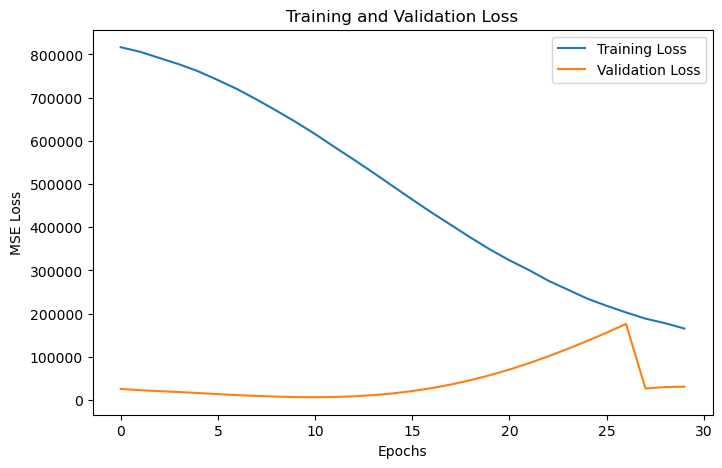

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Model saved as LSTM_RUL_model.h5
9/9 [==============================] - 2s 15ms/step


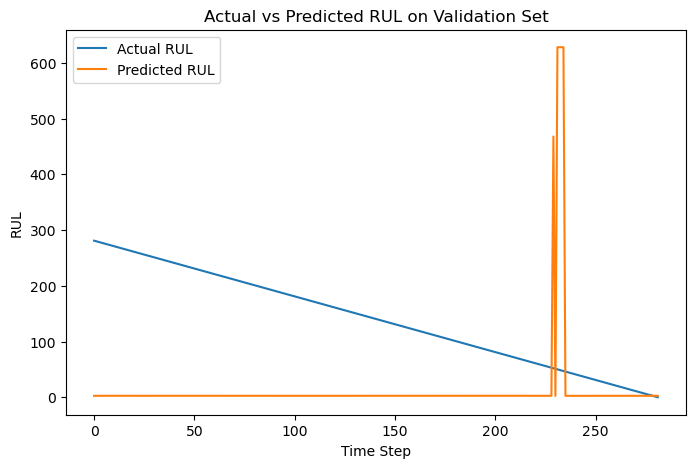

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import os

# -------------------------------
# Step 0: Set working directory (same as Milestone 1)
# -------------------------------
os.chdir(r"C:\Users\Lenovo\Untitled Folder\PrognosAI\Milestone_1")

# -------------------------------
# Step 1: Load preprocessed data (from Milestone 1)
# -------------------------------
filepath = "sensor_data.csv"  # Make sure this file exists
df = pd.read_csv(filepath)
df.fillna(method='ffill', inplace=True)

sensor_cols = ['SensorA', 'SensorB', 'SensorC']  # Adjust to your CSV
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

# Compute RUL
df['RUL'] = np.arange(len(df)-1, -1, -1)

# -------------------------------
# Step 2: Create rolling window sequences for LSTM input
# -------------------------------
def create_rolling_windows(df, window_size=30):
    X, y = [], []
    for i in range(len(df)-window_size):
        X.append(df[sensor_cols].iloc[i:i+window_size].values)
        y.append(df['RUL'].iloc[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_rolling_windows(df, window_size=window_size)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(" X_train shape:", X_train.shape)
print(" y_train shape:", y_train.shape)
print(" X_val shape:", X_val.shape)
print(" y_val shape:", y_val.shape)

# -------------------------------
# Step 3: Define LSTM model
# -------------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Predict RUL
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# -------------------------------
# Step 4: Train the model
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

# -------------------------------
# Step 5: Plot training & validation loss
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# -------------------------------
# Step 6: Save the trained model
# -------------------------------
model.save("LSTM_RUL_model.h5")
print(" Model saved as LSTM_RUL_model.h5")

# -------------------------------
# Step 7: Make predictions on validation set
# -------------------------------
y_pred = model.predict(X_val)
plt.figure(figsize=(8,5))
plt.plot(y_val, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Time Step')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL on Validation Set')
plt.legend()
plt.show()